#### Importing Necessary Libraries

In [1]:
#General Libraries
import pandas as pd
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
from scipy.stats import randint
from datetime import datetime
import imblearn
import seaborn as sns

#To supress Warnings
import warnings
warnings.filterwarnings('ignore')

#Preprocessing Libraries
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Over-Sampling, Data split, Hyper-Parameter Tuning, Cross Validation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold, GridSearchCV

#ML Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

#Metrics to validate ML Models
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

import plotly as py
import plotly.graph_objs as go
from ipywidgets import widgets
from scipy import special
import pickle

In [2]:
py.offline.init_notebook_mode(connected=True) 
import plotly.express as px

#### Importing dataset

In [4]:
df = pd.read_csv("Project Data.csv")

### Below are the classes in our dataset as per problem statement Class 1 is Positive and remaining are negative class
#### 1 - Recording of seizure activity
#### 2 - They recorder the EEG from the area where the tumor was located
#### 3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area
#### 4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed
#### 5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

In [5]:
df['Entries'] = 1
df.rename(columns = {'y':'Class'},inplace = True)
fig = px.pie(df, values='Entries', names='Class', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()
print("*"*120)
print("Findings:\nAll classes have equal entries in the dataset, as per description we have CLASS 1 which is termed as positive class \n(having Disease) rest all classes are negative")
print("*"*120)

************************************************************************************************************************
Findings:
All classes have equal entries in the dataset, as per description we have CLASS 1 which is termed as positive class 
(having Disease) rest all classes are negative
************************************************************************************************************************


In [6]:
#Converting Multi class problem into binary class since 1 is having disease and rest all [2 to 5] doesn't has disease
y_val = {1:1, 2:0, 3:0, 4:0, 5:0}
df['Class'] = df['Class'].map(y_val)

In [8]:
print("*"*100)
print(df['Class'].value_counts())
print("*"*100)
fig = px.pie(df, values='Entries', names='Class', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()
print("*"*120)
print("Findings:\nAfter conversion now we have class imbalance issue we will handle this later in the preprocessing stage")
print("*"*120)

****************************************************************************************************
0    9200
1    2300
Name: Class, dtype: int64
****************************************************************************************************


************************************************************************************************************************
Findings:
After conversion now we have class imbalance issue we will handle this later in the preprocessing stage
************************************************************************************************************************


In [9]:
x = np.linspace(0, np.pi, 300)

layout = go.Layout(
    title='<b>         Class feature wise Comparison </b>',
    yaxis=dict(
        title='<i>(Class)</i>'
    ),
    xaxis=dict(
        title='<i>(Observations)</i>'
    )
)


def update_plot(signals, freq):
    
    """
    This function updates the plot everytime a widget is changed
    """

    data = []
    for s in signals:
        trace1 = go.Scatter(
            x=df['Class'],
            y=df[freq],
            mode='lines',
            name='Class {}'.format(s),
            line=dict(
                shape='spline'
            )
        )
        data.append(trace1)

    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)
    

signals = widgets.SelectMultiple(options=list(range(1,6)), value=(1, ), description='Class')
freq = df.columns
widgets.interactive(update_plot, signals=signals, freq=freq)

interactive(children=(SelectMultiple(description='Class', index=(0,), options=(1, 2, 3, 4, 5), value=(1,)), Dr…

In [3]:
#Dropping Feature which is just an unique identifier and will not contributing much to dependent variable
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [9]:
#Checking for Duplicate columns
print("*"*100)
print("Number of Duplicate rows in our dataset : {}".format(df.duplicated().sum()))
print("*"*100)

****************************************************************************************************
Number of Duplicate rows in our dataset : 0
****************************************************************************************************


In [7]:
#Checking for data types
x = pd.DataFrame(df.dtypes, columns = ['Dtypes'])
print(x['Dtypes'].value_counts())
print("")
print("*"*100)
print("All data types are integer. Which also means we don't have nan values but still let's check")
print("*"*100)

int64    179
Name: Dtypes, dtype: int64

****************************************************************************************************
All data types are integer. Which also means we don't have nan values but still let's check
****************************************************************************************************


In [8]:
#Checking for Missing Values
missing_val = df.isnull().sum()
missing_val = pd.DataFrame(missing_val, index=None, columns=['Features'])
print("*"*100)
print("No of features with missing values {}".format(len(missing_val.iloc[np.where(missing_val['Features'] > 0)])))
print("*"*100)

****************************************************************************************************
No of features with missing values 0
****************************************************************************************************


************************************************************************************************************************


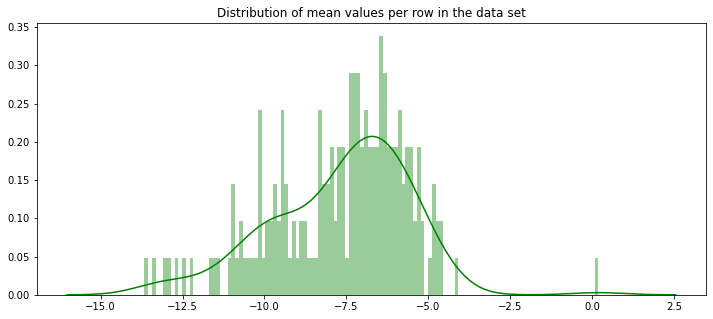

************************************************************************************************************************
Findings:
Data is somewhat normally distributed in terms of mean values per rows in the dataset, it is not completely skewed
************************************************************************************************************************


In [5]:
print("*"*120)
plt.figure(figsize = (12,5))
features = df.columns.values[0:179]
plt.title("Distribution of mean values per row in the data set")
sns.distplot(df[features].mean(axis=0),color="green",kde=True,bins=120)
plt.show()
print("*"*120)
print("Findings:\nData is somewhat normally distributed in terms of mean values per rows in the dataset, it is not completely skewed")
print("*"*120)

************************************************************************************************************************


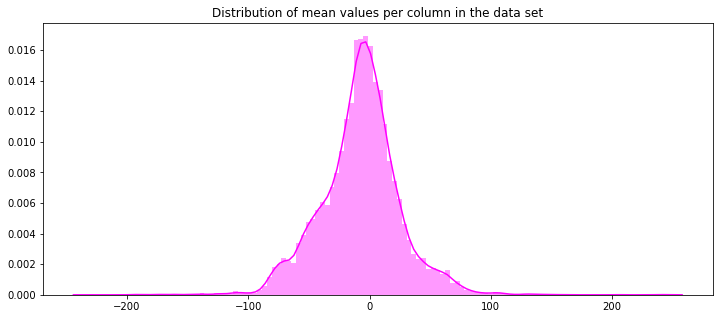

************************************************************************************************************************
Findings:
Data is normally distributed in terms of mean values per columns in the dataset
************************************************************************************************************************


In [12]:
print("*"*120)
plt.figure(figsize = (12,5))
plt.title("Distribution of mean values per column in the data set")
sns.distplot(df[features].mean(axis=1), color = "magenta", kde=True, bins=120)
plt.show()
print("*"*120)
print("Findings:\nData is normally distributed in terms of mean values per columns in the dataset")
print("*"*120)

************************************************************************************************************************


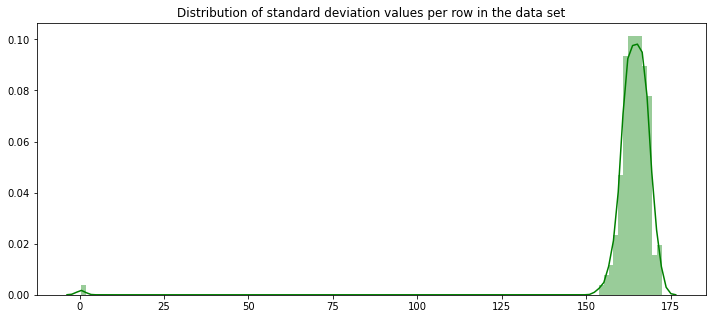

************************************************************************************************************************
Findings:
Data is left skewed with respect to standard deviation per row in the dataset
************************************************************************************************************************


In [13]:
print("*"*120)
plt.figure(figsize = (12,5))
plt.title("Distribution of standard deviation values per row in the data set")
sns.distplot(df[features].std(axis=0),color="green",kde=True,bins=120)
plt.show()
print("*"*120)
print("Findings:\nData is left skewed with respect to standard deviation per row in the dataset")
print("*"*120)

************************************************************************************************************************


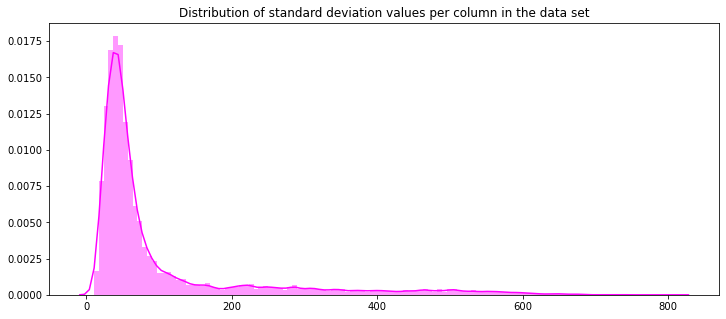

************************************************************************************************************************
Data is right skewed with respect to standard deviation per column in the dataset
************************************************************************************************************************


In [14]:
print("*"*120)
plt.figure(figsize = (12,5))
plt.title("Distribution of standard deviation values per column in the data set")
sns.distplot(df[features].std(axis=1),color="magenta",kde=True,bins=120)
plt.show()
print("*"*120)
print("Data is right skewed with respect to standard deviation per column in the dataset")
print("*"*120)

*******************************************************************************************************************************


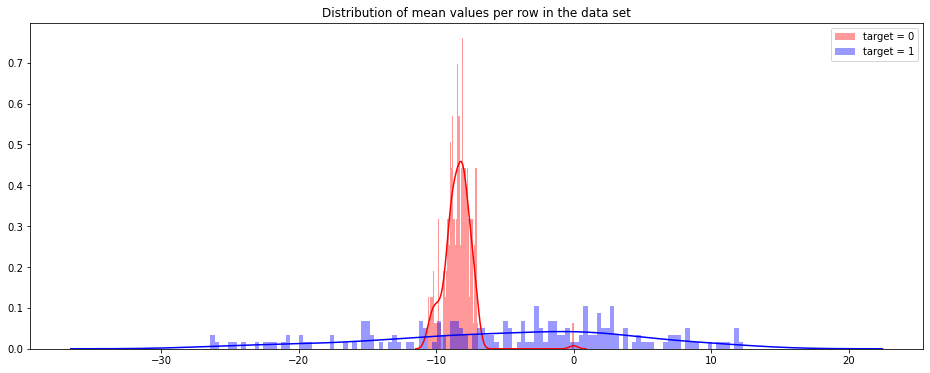

*******************************************************************************************************************************
Data distribution with respect to dependent variable in the majority and minority class seems to be evenly spread with respect to the mean in the dataset
*******************************************************************************************************************************


In [19]:
print("*"*127)
t0 = df.loc[df['y'] == 0]
t1 = df.loc[df['y'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the data set")
sns.distplot(t0[features].mean(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); 
plt.show()
print("*"*127)
print("Data distribution with respect to dependent variable in the majority and minority class seems to be evenly spread with respect to the mean in the dataset")
print("*"*127)

*******************************************************************************************************************************


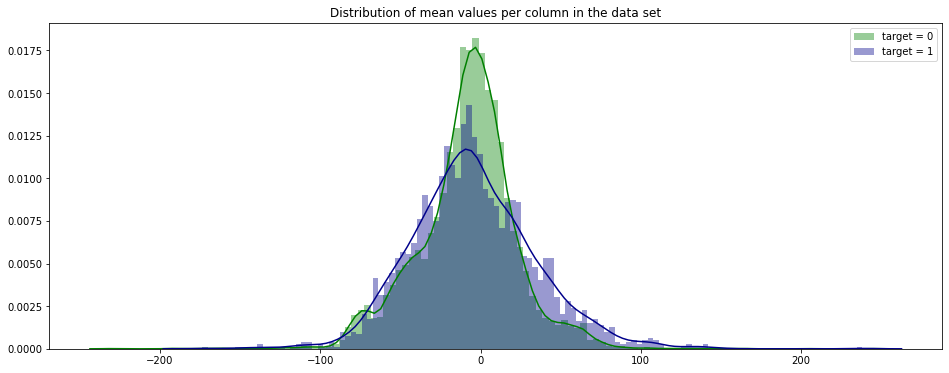

*******************************************************************************************************************************
Data distribution with respect to dependent variable in the majority and minority class seems to be evenly spread with respect to the mean in the dataset
*******************************************************************************************************************************


In [21]:
print("*"*127)
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the data set")
sns.distplot(t0[features].mean(axis=1),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()
print("*"*127)
print("Data distribution with respect to dependent variable in the majority and minority class seems to be evenly spread with respect to the mean in the dataset")
print("*"*127)

#### Dividing Data into train test split (Ratio 75:25)

In [6]:
def training_testing_split(ind_var, dep_var):
    X_train,y_train,X_test,y_test = train_test_split(ind_var, dep_var, test_size=0.25, random_state=1, stratify = dep_var)
    return X_train,y_train,X_test,y_test

In [7]:
X_train, y_train, X_test, y_test = training_testing_split(df.iloc[:,0:178], df['y'])

In [18]:
print(X_train.shape)
print(X_test.shape)
print("\n")
print(y_train.shape)
print(y_test.shape)

(8625, 178)
(8625,)


(2875, 178)
(2875,)


#### Standardizing the dataset

In [8]:
# Standardizing the dataset
def standardizing(x):
    scaler_1 = StandardScaler()
    X_train_normalized_s1 = scaler_1.fit_transform(x)
    X_train_normalized1 = pd.DataFrame(X_train_normalized_s1, columns = x.columns)
    #X_train_normalized1[y] = X_train_normalized1[y].astype(int)
    #X_train_normalized1[y] = df[y].values
    return X_train_normalized_s1, X_train_normalized1

In [9]:
#in function STANDARDIZING first option is dataframe and second option is target variable name
# FOR TRAIN SET
X_train_normalized_s1, X_train_normalized1 = standardizing(X_train)
# FOR TEST SET
y_train_normalized_s1, y_train_normalized1 = standardizing(y_train)

### Checking Variable Inflation Factor, If VIF is greater than 5 we will eliminate the variable

In [15]:
#Checking VIF amongst available features
def vif_func(X_train_normalized_s1,X_train_normalized1):
    vif1 = pd.DataFrame()
    vif1["Features"] = X_train_normalized1.columns
    vif1["VIF"] = [variance_inflation_factor(X_train_normalized_s1,i) for i in range(X_train_normalized1.shape[1])]
    return vif1

In [16]:
#in function VIF_FUNC first option is normal dataframe and second option is normalized data
# FOR TRAIN SET
vif1 = vif_func(X_train_normalized_s1,X_train_normalized1)

# FOR TEST SET
vif_test = vif_func(y_train_normalized_s1, y_train_normalized1)

In [17]:
print("Number of features having high multicollinearity are {}".format(len(vif1.iloc[np.where(vif1["VIF"]>5)])))

if(len(X_train_normalized1.columns) == len(vif1.iloc[np.where(vif1["VIF"]>5)])):
    print("\nAll features have high multicollinearity!\n")

B1 = min(vif1['VIF'].iloc[np.where(vif1["VIF"]!=0)])
B2 = min(vif1['Features'].loc[np.where(vif1["VIF"]== B1)])

B3 = max(vif1['VIF'].iloc[np.where(vif1["VIF"]!=0)])
B4 = max(vif1['Features'].iloc[np.where(vif1["VIF"]==B3)])

print("Feature having minimum VIF is {} and VIF score is {}\n".format(B2, B1))
print("Feature having maximum VIF is {} and VIF score is {}".format(B4, B3))

Number of features having high multicollinearity are 178

All features have high multicollinearity!

Feature having minimum VIF is X1 and VIF score is 61.232731706941834

Feature having maximum VIF is X38 and VIF score is 577.7812023751094


In [18]:
print("Number of features having high multicollinearity are {}".format(len(vif_test.iloc[np.where(vif_test["VIF"]>5)])))

if(len(y_train_normalized1.columns) == len(vif_test.iloc[np.where(vif_test["VIF"]>5)])):
    print("\nAll features have high multicollinearity!\n")

B1 = min(vif_test['VIF'].iloc[np.where(vif_test["VIF"]!=0)])
B2 = min(vif_test['Features'].loc[np.where(vif_test["VIF"]== B1)])

B3 = max(vif_test['VIF'].iloc[np.where(vif_test["VIF"]!=0)])
B4 = max(vif_test['Features'].iloc[np.where(vif_test["VIF"]==B3)])

print("Feature having minimum VIF is {} and VIF score is {}\n".format(B2, B1))
print("Feature having maximum VIF is {} and VIF score is {}".format(B4, B3))

Number of features having high multicollinearity are 178

All features have high multicollinearity!

Feature having minimum VIF is X1 and VIF score is 77.54073101770086

Feature having maximum VIF is X162 and VIF score is 948.8775562775533


#### PCA -> (To reduce multi-collinearity amongst the variables)

In [19]:
#Implementing PCA to reduce features and removing multi-collinearity
def pca_plot(x):
    var_ratio = {}
    for i in range(0,178):
        pca = PCA(n_components = i)
        cr_pca = pca.fit(x)
        var_ratio[i] = sum(cr_pca.explained_variance_ratio_)
        pd.Series(var_ratio).plot()
        plt.savefig('pca_plot')
    return pd.Series(var_ratio).plot()

<AxesSubplot:>

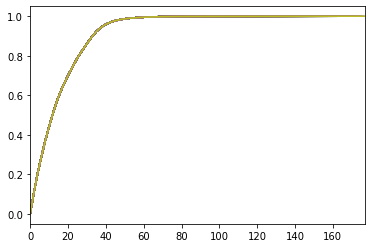

In [20]:
# FOR TRAIN SET
pca_plot(X_train_normalized1)

<AxesSubplot:>

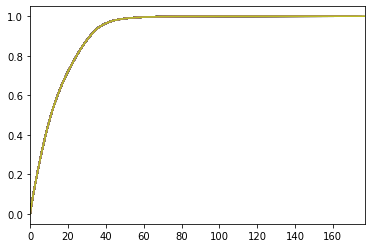

In [21]:
# FOR TEST SET
pca_plot(y_train_normalized1)

In [10]:
def apply_train_pca(x):
    pca = PCA()
    pca_data = pca.fit(x)
    pca_data = pca.transform(x)
    X_train_pca = pd.DataFrame(pca_data)
    return X_train_pca

In [22]:
def apply_test_pca(x):
    pca_data = pca.transform(x)
    y_train_pca = pd.DataFrame(pca_data)
    return y_train_pca

In [11]:
# FOR TRAIN SET
X_train_pca = apply_train_pca(X_train_normalized1)

# FOR TEST SET
y_train_pca = apply_train_pca(y_train_normalized1)

In [12]:
print(X_train_pca.shape)
print(y_train_pca.shape)

(8625, 178)
(2875, 178)


#### Performing weighting to handle class imbalance problem

In [17]:
#Unique classes
# FOR TRAIN SET
unique_classes_train = list(X_test.unique())

# FOR TEST SET
unique_classes_test = list(y_test.unique())

In [75]:
X_test.value_counts()[0]

6900

In [77]:
df.loc[df['y'] == 0].shape[0]

9200

In [18]:
train_dict = {}
for i in unique_classes_train:
    train_dict[i] = X_train_pca.shape[0] / ((X_test.value_counts()[i]) * len(unique_classes_train))
    
test_dict = {}
for i in unique_classes_test:
    test_dict[i] = y_train_pca.shape[0] / ((y_test.value_counts()[i]) * len(unique_classes_test))

In [82]:
print(train_dict)
print(test_dict)

{0: 0.625, 1: 2.5}
{0: 0.625, 1: 2.5}


#### Performing over sampling as well to handle class imbalance issue we will select method based on accuracy / precision

In [13]:
def over_sample(X_train, X_test):
    smote = SMOTE(random_state = 0)
    X_train_smote, X_test_smote = smote.fit_sample(X_train, X_test)
    return X_train_smote, X_test_smote

In [14]:
X_train_smote, X_test_smote = over_sample(X_train, X_test)

## Modelling
#### 1. Random Forest Classifier
#### Using weights

In [19]:
rf = RandomForestClassifier(class_weight = train_dict)
rf_model = rf.fit(X_train, X_test)
rf_predictions = rf_model.predict(y_train)

In [32]:
def model_validation_metrics(predictions, actual):
    #Build Confusion Matrix
    print("*"*100)
    CM = pd.crosstab(predictions, actual)
    print("Confusion Matrix :\n{}".format(CM))
    print("*"*100)
    acc = accuracy_score(predictions, actual)
    print("\nAccuracy of the RF Model is\n{}".format(acc * 100))
    print("*"*100)
    classification_scores=classification_report(predictions, actual)
    print(classification_scores)
    print("*"*100)

In [30]:
model_validation_metrics(rf_predictions, y_test)

****************************************************************************************************
Confusion Matrix :
y         0    1
row_0           
0      2221   14
1        79  561
****************************************************************************************************

Accuracy of the RF Model is
96.76521739130435
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2235
           1       0.98      0.88      0.92       640

    accuracy                           0.97      2875
   macro avg       0.97      0.94      0.95      2875
weighted avg       0.97      0.97      0.97      2875

****************************************************************************************************


#### Hyper Parameter Tuning

In [29]:
# COSTLY FUNCTION #

test = RandomForestClassifier(n_jobs = -1)
rf_p_dist = {'max_depth':[3,5,7,10, None],
             'n_estimators': [10,100,200,300,400,500],
             'max_features': randint(1,10),
             'criterion': ['gini','entropy'],
             'bootstrap': [True, False],
             'min_samples_leaf': randint(1,5)
            }
def hypertuning_rf(test, p_dist, nbr_iter, X, Y):
    rdmsearch = RandomizedSearchCV(test, param_distributions=rf_p_dist, n_iter = nbr_iter, cv=9)
    rdmsearch.fit(X,Y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score
rf_parameters, rf_ht_score = hypertuning_rf(test, rf_p_dist, 15, X_train_smote_dummy_ht_final.iloc[:,0:178], X_train_smote_dummy_ht_final.iloc[:,178])

In [25]:
# To create small subset for Hyper parameter tuning to save time
X_train_smote['y'] = X_test_smote.values
X_train_smote_dummy_ht_final = X_train_smote.iloc[np.where(X_train_smote['y'] == 1)][0:1000]
a123abc = X_train_smote.iloc[np.where(X_train_smote['y'] == 0)][0:1000]
X_train_smote_dummy_ht_final = X_train_smote_dummy_ht_final.append(a123abc)
X_train_smote.drop(['y'], axis = 1, inplace = True)

#### Hyper Parameter Tuning for Random Forest

##### Using weights

In [30]:
#rf_ht=RandomForestClassifier(class_weight = out_dict, bootstrap=True,criterion='entropy',max_depth=10,max_features=8,min_samples_leaf=2,n_estimators=500)
rf_ht = RandomForestClassifier(class_weight = train_dict)
rf_ht.set_params(**rf_parameters)
rf_model_ht= rf_ht.fit(X_train, X_test)
rf_predictions_ht = rf_model_ht.predict(y_train)

In [33]:
model_validation_metrics(rf_predictions_ht, y_test)

****************************************************************************************************
Confusion Matrix :
y         0    1
row_0           
0      2278   70
1        22  505
****************************************************************************************************

Accuracy of the RF Model is
96.8
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2348
           1       0.88      0.96      0.92       527

    accuracy                           0.97      2875
   macro avg       0.93      0.96      0.95      2875
weighted avg       0.97      0.97      0.97      2875

****************************************************************************************************


##### Using SMOTE

In [27]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_smote, X_test_smote)
rf_predictions = rf_model.predict(y_train)

In [31]:
model_validation_metrics(rf_predictions, y_test)

****************************************************************************************************
Confusion Matrix :
y         0    1
row_0           
0      2221   14
1        79  561
****************************************************************************************************

Accuracy of the RF Model is
96.76521739130435
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2235
           1       0.98      0.88      0.92       640

    accuracy                           0.97      2875
   macro avg       0.97      0.94      0.95      2875
weighted avg       0.97      0.97      0.97      2875

****************************************************************************************************


#### Hyper Parameter Tuning for Random Forest
#### Using SMOTE

In [38]:
#rf_ht=RandomForestClassifier(bootstrap=True,criterion='entropy',max_depth=10,max_features=8,min_samples_leaf=2,n_estimators=500)
rf_ht = RandomForestClassifier(n_jobs = -1)
rf_ht.set_params(**rf_parameters)
rf_model_ht= rf_ht.fit(X_train_smote, X_test_smote)
rf_predictions_ht = rf_model_ht.predict(y_train)

In [39]:
model_validation_metrics(rf_predictions_ht, y_test)

****************************************************************************************************
Confusion Matrix :
y         0    1
row_0           
0      2226   20
1        74  555
****************************************************************************************************

Accuracy of the RF Model is
96.7304347826087
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2246
           1       0.97      0.88      0.92       629

    accuracy                           0.97      2875
   macro avg       0.97      0.94      0.95      2875
weighted avg       0.97      0.97      0.97      2875

****************************************************************************************************


#### 2. Support Vector Classifier
#### Using weights

In [98]:
svm_class = svm.SVC(class_weight = train_dict)
svm_model = svm_class.fit(X_train, X_test)
svm_predictions = svm_model.predict(y_train)

In [99]:
model_validation_metrics(svm_predictions, y_test)

****************************************************************************************************
Confusion Matrix :
y         0    1
row_0           
0      2250   28
1        50  547
****************************************************************************************************

Accuracy of the RF Model is
97.28695652173913
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2278
           1       0.95      0.92      0.93       597

    accuracy                           0.97      2875
   macro avg       0.96      0.95      0.96      2875
weighted avg       0.97      0.97      0.97      2875

****************************************************************************************************


#### Hyper Parameter Tuning for Support Vector Classifier
#### Using weights

In [95]:
svm_class_ht = svm.SVC(class_weight = train_dict, kernel= 'rbf', gamma= 0.01, C= 10)
svm_model_ht = svm_class_ht.fit(X_train, X_test)
svm_predictions_ht = svm_model_ht.predict(y_train)

In [96]:
model_validation_metrics(svm_predictions_ht, y_test)

****************************************************************************************************
Confusion Matrix :
y         0    1
row_0           
0      2269   48
1        31  527
****************************************************************************************************

Accuracy of the RF Model is
97.25217391304348
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2317
           1       0.92      0.94      0.93       558

    accuracy                           0.97      2875
   macro avg       0.95      0.96      0.96      2875
weighted avg       0.97      0.97      0.97      2875

****************************************************************************************************


#### Using SMOTE

In [97]:
svm_class = svm.SVC()
svm_model = svm_class.fit(X_train_smote, X_test_smote)
svm_predictions = svm_model.predict(y_train)

In [98]:
model_validation_metrics(svm_predictions, y_test)

****************************************************************************************************
Confusion Matrix :
y         0    1
row_0           
0      2240   23
1        60  552
****************************************************************************************************

Accuracy of the RF Model is
97.11304347826088
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2263
           1       0.96      0.90      0.93       612

    accuracy                           0.97      2875
   macro avg       0.97      0.95      0.96      2875
weighted avg       0.97      0.97      0.97      2875

****************************************************************************************************


#### Hyper Parameter Tuning for Support Vector Classifier
#### Using SMOTE

In [ ]:
rf_p_dist = {'C': [0.1, 1, 10, 100, 1000],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel': ['rbf']}

def hypertuning_svm(test, p_dist, n2br_iter, X, Y):
    rdmsearch = RandomizedSearchCV(test, param_distributions=p_dist, n_iter = nbr_iter, cv=9)
    rdmsearch.fit(X,Y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

svm_parameters, svm_ht_score = hypertuning_svm(svm_class, rf_p_dist, 20, X_train_smote, X_test_smote)

print(svm_parameters)
print(svm_ht_score)

In [99]:
svm_class_ht = svm.SVC()
svm_class_ht.set_params(**svm_parameters)
svm_model_ht = svm_class_ht.fit(X_train_smote, X_test_smote)
svm_predictions_ht = svm_model_ht.predict(y_train)

In [100]:
model_validation_metrics(svm_predictions_ht, y_test)

****************************************************************************************************
Confusion Matrix :
y         0    1
row_0           
0      2269   54
1        31  521
****************************************************************************************************

Accuracy of the RF Model is
97.04347826086956
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2323
           1       0.91      0.94      0.92       552

    accuracy                           0.97      2875
   macro avg       0.95      0.96      0.95      2875
weighted avg       0.97      0.97      0.97      2875

****************************************************************************************************


#### KNN Algorithm (As suggested by AutoML TPOT Library)

In [31]:
knn = KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')
knn_model = knn.fit(X_train_smote, X_test_smote)
knn_predictions = knn_model.predict(y_train)

In [32]:
model_validation_metrics(knn_predictions, y_test)

****************************************************************************************************
Confusion Matrix :
y         0    1
row_0           
0      2278   96
1        22  479
****************************************************************************************************

Accuracy of the RF Model is
95.89565217391305
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2374
           1       0.83      0.96      0.89       501

    accuracy                           0.96      2875
   macro avg       0.91      0.96      0.93      2875
weighted avg       0.96      0.96      0.96      2875

****************************************************************************************************


#### Creating Pickle File of best performing model

In [43]:
def create_pickle_dump(rf_model_ht):
    Pkl_Filename = "RFC_Model.pkl"
    with open(Pkl_Filename, 'wb') as file:
        pickle.dump(rf_model_ht, file)

In [46]:
create_pickle_dump(rf_model_ht)